# EmotionX data explore
Andrew Nguyen, 09/06/2019

Summary: <br>
data exploration and initial steps

In [1]:
# Adding project root and custom functions
from os import listdir, getcwd
from os.path import isfile, join
import sys
from pathlib import Path

def find_root_dir():
    # find config.py
    path = Path(getcwd()).parent
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

    while "config.py" not in onlyfiles:
        path = path.parent
        onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
        
    return path

ROOT_DIR = str(find_root_dir())
sys.path.append(ROOT_DIR)

from config import get_project_root
# custom functs
from src.features import build_features
from src.visualization.visualize import plot_confusion_matrix

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

import random
from collections import Counter

from nltk import ngrams
from nltk.tokenize import TweetTokenizer

In [3]:
D1_PATH = "../data/raw/EmotionPush/emotionpush.augmented.json"
D2_PATH = "../data/raw/Friends/friends.augmented.json"

# df = build_features.to_df(D1_PATH)

In [4]:
# df

In [5]:
file = D1_PATH
if file:
    with open(file, 'r') as f:
        datastore = json.load(f)    

utters = []
for idx, convo in enumerate(datastore):
    for i in range(len(convo)):
        # for each convo, extract each 3 turn utterance | i - 1 | utterance | i + 1 |
        # Each utterance has the context before and after
        utter_context = []

        if (i - 1) >= 0:
            utter_context.append(convo[i-1])
        else:
            utter_context.append(None)

        utter_context.append(convo[i])

        if (i + 1) < len(convo):
            utter_context.append(convo[i+1])
        else:
            utter_context.append(None)

        utter_context.append(idx) # save convo id

        utters.append(utter_context)

# Convert to pandas initialise format
utters2 = []
for u in utters:
    d = {}
    if u[0] != None:
        d["emotion1"] = u[0]["emotion"]
        d["utterance1"] = u[0]["utterance"]

    d["emotion2"] = u[1]["emotion"]
    d["utterance2"] = u[1]["utterance"]

    if u[2] != None:    
        d["emotion3"] = u[2]["emotion"]
        d["utterance3"] = u[2]["utterance"]

    d["convoId"] = u[3]
    d["annotation"] = u[1]["annotation"]

    utters2.append(d)  

df = pd.DataFrame(utters2)

## Sample of the data & format

In [6]:
datastore[237]


[{'speaker': '100003245927356',
  'utterance': 'What about a pay plan',
  'emotion': 'neutral',
  'annotation': '5000000',
  'utterance_de': 'What about a salary plan?',
  'utterance_fr': 'What about a compensation plan',
  'utterance_it': 'What about a payment plan'},
 {'speaker': '100003245927356',
  'utterance': 'What are you gonna do about references?',
  'emotion': 'neutral',
  'annotation': '4000010',
  'utterance_de': 'What are you doing with references?',
  'utterance_fr': 'What will you do about references?',
  'utterance_it': 'What will you do about the references?'},
 {'speaker': '100003639669704',
  'utterance': 'Idk',
  'emotion': 'neutral',
  'annotation': '4001000',
  'utterance_de': 'idk',
  'utterance_fr': 'idk',
  'utterance_it': 'idk'},
 {'speaker': '100003639669704',
  'utterance': 'Did you take stafford loans?',
  'emotion': 'neutral',
  'annotation': '4000010',
  'utterance_de': 'Have you taken Stafford loans?',
  'utterance_fr': 'Have you taken out loans at Staff

In [7]:
# index 237 for emotionpush example, 45 for friends
datastore[237]

for idx, t in enumerate(datastore[237]):
    print("Turn {}: {}".format(idx+1, t["utterance"]))

Turn 1: What about a pay plan
Turn 2: What are you gonna do about references?
Turn 3: Idk
Turn 4: Did you take stafford loans?
Turn 5: I think so
Turn 6: who'd you put?
Turn 7: according to college confidential they're so the feds can get in contact with you if you move without changing your address on the site
Turn 8: Actually I'm not sure if I did


## Exploratory Stats

In [8]:
# 1000 facebook chats of varying length 5 - 24 turns
# 29,245 individual replies/turns
# [neutral, joy, sadness, fear, anger,  surprise, disgust] Emotions 
# "non-neutral" if no majority given (5 annotators)
# Speakers can reply in multiple consecutive turns

# FRIENDS:
# 1000 dialogue conversations from the "Friends" tv show 
# Dataset specific:
# Friends: "Oh Ross, you're so great. [she playfully rubs his head and gets up]"
# Scene actions wrapped in []

## Conversation length

In [9]:
convoLen = []
for convo in datastore:
    convoLen.append(len(convo))

s = pd.Series(convoLen)

In [10]:
"Min convo len is {}, Max convo len is {}".format(s.min(), s.max())

'Min convo len is 5, Max convo len is 24'

In [11]:
s.describe()

count    1000.000000
mean       14.742000
std         5.274776
min         5.000000
25%         9.750000
50%        14.500000
75%        19.250000
max        24.000000
dtype: float64

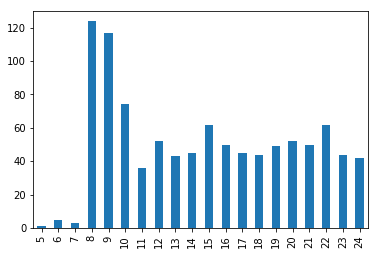

In [12]:
s.groupby(s).count().plot.bar()

### - Longest Convo detail

In [13]:
for convo in datastore:
    if len(convo) == 24:
        x = convo

In [14]:
for idx, t in enumerate(x):
    print("T{}, Speaker {}: {} -> ({})".format(idx+1, t["speaker"], t["utterance"], t["emotion"]))

T1, Speaker 645612368: Haha are you serious -> (surprise)
T2, Speaker 1510802066: The girl told her to collect it from neville apt -> (neutral)
T3, Speaker 645612368: Smart decision -> (joy)
T4, Speaker 1510802066: But don't think she will -> (non-neutral)
T5, Speaker 1510802066: What. I want to punch! -> (anger)
T6, Speaker 1510802066: Btw did the VO ever ask for ur tenth n twelfth border marksheet? -> (neutral)
T7, Speaker 645612368: So you spend 140$? On that? Pointless.. So many better options. Punch her. For free -> (disgust)
T8, Speaker 645612368: Dude the vo didn't ask me anything, no dividend -> (neutral)
T9, Speaker 645612368: Documents -> (neutral)
T10, Speaker 645612368: But keep it just in case. If you have it -> (neutral)
T11, Speaker 1510802066: 70$ if we share -> (neutral)
T12, Speaker 645612368: No harm -> (neutral)
T13, Speaker 645612368: Major waste -> (disgust)
T14, Speaker 645612368: Appointment tomorrow? -> (neutral)
T15, Speaker 645612368: Take a copy -> (neutral)

In [15]:
# Summary:
# - One convo
# - Multiple consecutive replies from a speaker

## Emotion proportions

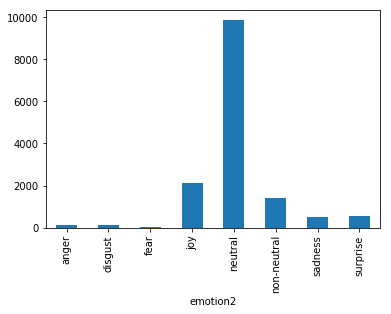

In [16]:
df.groupby("emotion2")["utterance2"].count().plot.bar()

## Percentage

In [17]:
temp = df.groupby("emotion2")["utterance2"].count()
temp.apply(lambda x: x/temp.sum()).sort_values()

emotion2
fear           0.002849
disgust        0.007190
anger          0.009497
sadness        0.034866
surprise       0.038462
non-neutral    0.096188
joy            0.142450
neutral        0.668498
Name: utterance2, dtype: float64

## Check missing values

In [18]:
df[["emotion2"]].isna()[df.emotion2 == True]

,emotion2


## Words per turn

In [19]:
tokenizer = TweetTokenizer()
df["wordsPerTurn"] = df.utterance2.apply(lambda x: len(x.split(" ")))

In [20]:
s = df.wordsPerTurn

"Min words per turn {}, Max words per turn {}".format(s.min(), s.max())

'Min words per turn 1, Max words per turn 183'

In [21]:
df[df.wordsPerTurn == 183] # This is a valid 183 word turn

,annotation,convoId,emotion1,emotion2,emotion3,utterance1,utterance2,utterance3,wordsPerTurn
11903,2010101,797,NaN,non-neutral,neutral,NaN,"Among several other reasons, consider this par...","""",183


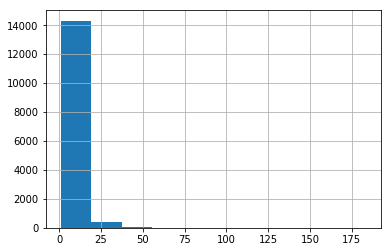

In [22]:
# range between 1 - 183
df["wordsPerTurn"].hist()

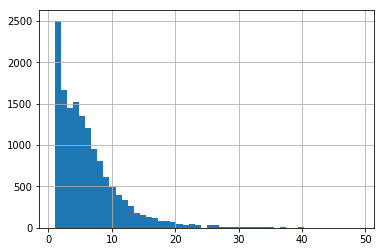

In [23]:
s = df.wordsPerTurn
s[s <= 50].hist(bins=50)

## Word level exploration

In [24]:
s = df.utterance2

text = ' '.join(s.values)

In [25]:
tokenizer = TweetTokenizer(reduce_len=True, preserve_case=False)

In [26]:
text_trigrams = [i for i in ngrams(tokenizer.tokenize(text), 3)]
Counter(text_trigrams).most_common(30)

[(('i', 'love', 'you'), 76),
 (('i', 'want', 'to'), 47),
 (('a', 'lot', 'of'), 45),
 (('!', '!', '!'), 42),
 (('i', 'need', 'to'), 42),
 (('i', 'have', 'a'), 41),
 (('i', "don't", 'think'), 35),
 (('do', 'you', 'have'), 32),
 (('let', 'me', 'know'), 32),
 (("i'm", 'going', 'to'), 32),
 (('i', "don't", 'know'), 31),
 (('i', 'have', 'to'), 29),
 (('i', 'think', 'i'), 26),
 (('?', '?', '?'), 24),
 (('you', 'want', 'to'), 24),
 (('(', 'y', ')'), 23),
 (('at', 'time', '_1'), 23),
 (('one', 'of', 'the'), 23),
 (('love', 'you', 'i'), 21),
 (('be', 'able', 'to'), 20),
 (('?', 'i', 'think'), 20),
 (('let', 'you', 'know'), 19),
 (('if', 'you', 'want'), 19),
 (('what', 'are', 'you'), 18),
 (('love', 'you', 'too'), 18),
 (('i', 'feel', 'like'), 18),
 (('oh', 'my', 'god'), 17),
 (('to', 'go', 'to'), 17),
 (('i', "don't", 'want'), 17),
 (('i', "don't", 'have'), 17)]

In [27]:
Counter(text_trigrams).most_common()[:-30-1:-1]
# c.most_common()[:-n-1:-1] -> Least common n

[(('plain', 'sight', 'loolll'), 1),
 (('in', 'plain', 'sight'), 1),
 (('hidden', 'in', 'plain'), 1),
 (('humor', 'hidden', 'in'), 1),
 (('adult', 'humor', 'hidden'), 1),
 (('of', 'adult', 'humor'), 1),
 (('lot', 'of', 'adult'), 1),
 (('show', 'but', "there's"), 1),
 (('kids', 'show', 'but'), 1),
 (('a', 'kids', 'show'), 1),
 (('be', 'a', 'kids'), 1),
 (('its', 'supposed', 'to'), 1),
 (('lolll', 'its', 'supposed'), 1),
 (('weird', 'lolll', 'its'), 1),
 (("it's", 'weird', 'lolll'), 1),
 (('it', "it's", 'weird'), 1),
 (('watch', 'it', "it's"), 1),
 (('used', 'to', 'watch'), 1),
 (('cartoon', '?', 'i'), 1),
 (('that', 'cartoon', '?'), 1),
 (('likee', 'that', 'cartoon'), 1),
 (('you', 'likee', 'that'), 1),
 (('lolll', 'you', 'likee'), 1),
 (('it', 'lolll', 'you'), 1),
 (('on', 'it', 'lolll'), 1),
 (('_112', 'on', 'it'), 1),
 (('person', '_112', 'on'), 1),
 (('with', 'person', '_112'), 1),
 (('shirt', 'with', 'person'), 1),
 (('a', 'shirt', 'with'), 1)]

In [28]:
# Summary:
# -> Mispellings
# -> Not that useful

## Look at a couple of annotator scores

In [29]:
def f(convo):
    # get all speakers
    speakers = []
    for t in convo:
        if t["speaker"] not in speakers:
            speakers.append(t["speaker"])
    
    print("[neutral, joy, sadness, fear, anger,  surprise, disgust]")
    for idx, t in enumerate(convo):
        print("T{} Speaker {}: {} -> ({} -> {})".format(idx+1,speakers.index(t["speaker"])+1,t["utterance"],t["annotation"],t["emotion"]))
        

In [30]:
f(datastore[3])

[neutral, joy, sadness, fear, anger,  surprise, disgust]
T1 Speaker 1: Have u seen what the heart smiley does on messengers -> (3100010 -> neutral)
T2 Speaker 1: Watch -> (3100010 -> neutral)
T3 Speaker 2: Show me the love -> (3200000 -> neutral)
T4 Speaker 1: Wait for it.. -> (5000000 -> neutral)
T5 Speaker 1: Click on it -> (4100000 -> neutral)
T6 Speaker 2: Nothing -> (4010000 -> neutral)
T7 Speaker 2: When I send that there's random hearts flying -> (3000020 -> neutral)
T8 Speaker 1: Yes exactly -> (2300000 -> joy)
T9 Speaker 1: Hearts flying -> (1300010 -> joy)
T10 Speaker 1: For u -> (2300000 -> joy)
T11 Speaker 1: All the way from bharat -> (3200000 -> neutral)
T12 Speaker 2: Not when I click on yours though -> (3020000 -> neutral)
T13 Speaker 1: Ok then it happens s without clicking is it -> (4000010 -> neutral)
T14 Speaker 1: Doesn't it fly on yours with my emoji? -> (3000020 -> neutral)
T15 Speaker 2: Muchos gracias -> (1400000 -> joy)
T16 Speaker 2: No nothing happens with y

In [31]:
# Summary:
# -> locations are anonymised (location_83)

## Distribution of the Annotator Scores

In [32]:
# Annotation
# 5 Votes
# [neutral, joy, sadness, fear, anger,  surprise, disgust]
# 11 choose 6 -> 462 

In [33]:
s = df.annotation

In [34]:
len(s.unique()) 

344

In [35]:
# Find 90% of the annonators
len(s)*0.7

10319.4

In [36]:
pd.DataFrame()

""


In [37]:
d = s.groupby(s).agg("count").sort_values(ascending=False).to_frame("count")
d["aggCount"] = 0

for i in range(len(d)):
    # get prev aggCount
    prev = 0
    if i-1 >= 0:
        prev = d.iat[i-1, 1]
        
    val = d.iat[i,0]
    
    d.iat[i,1] = prev + val

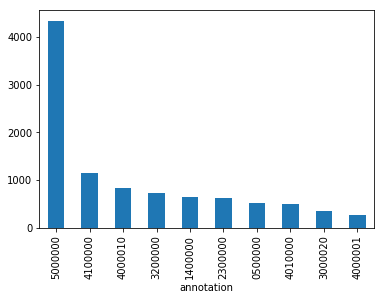

In [38]:
d[d.aggCount < 10000]["count"].plot.bar()
# [neutral, joy, sadness, fear, anger,  surprise, disgust]

In [39]:
# Summary:
# -> not that informative? 
# -> 70% of all annotations are shown in the above graph


## Markov Chain analysis

In [40]:
# Question:
# - Does having the prev turn help predict the emotion of the current turn?

# Experiment:
# - Compute Markov Transition matrix to figure out relationship

In [41]:
df

,annotation,convoId,emotion1,emotion2,emotion3,utterance1,utterance2,utterance3,wordsPerTurn
0,4001000,0,NaN,neutral,neutral,NaN,Sorry to bother you but do you have the 270 te...,What's it called,11
1,4000010,0,neutral,neutral,neutral,Sorry to bother you but do you have the 270 te...,What's it called,Digital design and principles I think,3
2,5000000,0,neutral,neutral,neutral,What's it called,Digital design and principles I think,I don't think so?,6
3,3000020,0,neutral,neutral,neutral,Digital design and principles I think,I don't think so?,I could be wrong,4
4,5000000,0,neutral,neutral,neutral,I don't think so?,I could be wrong,Ok that's fine. I'm just trying hard to avoid ...,4
5,3020000,0,neutral,neutral,neutral,I could be wrong,Ok that's fine. I'm just trying hard to avoid ...,You don't need the boom,12
6,5000000,0,neutral,neutral,neutral,Ok that's fine. I'm just trying hard to avoid ...,You don't need the boom,*book,5
7,5000000,0,neutral,neutral,neutral,You don't need the boom,*book,"If I do have it, I never used it",1
8,4000010,0,neutral,neutral,non-neutral,*book,"If I do have it, I never used it",But you had a good professor,9
9,2110100,0,neutral,non-neutral,neutral,"If I do have it, I never used it",But you had a good professor,I mean you can use the notes,6


In [42]:
# Create Transition Matrix P
states = ["neutral", "joy", "sadness", "fear", "anger",  "surprise", "disgust", "non-neutral"]
numStates = len(states)

p = [ [0 for j in range(numStates)] for i in range(numStates) ]
pnorm = [ [0 for j in range(numStates)] for i in range(numStates) ]

In [43]:
# count transitions
for i in range(len(df)):
    prev = df.iat[i,2] # emotion 1
    now = df.iat[i,3] # emotion 2
    
    if pd.notna(prev):
        iprev = states.index(prev)
        inow = states.index(now)
        p[iprev][inow] = p[iprev][inow] + 1
        
# normalize        
for i in range(len(p)):
    for j in range(len(p[0])):
        if sum(p[i]) != 0:
            pnorm[i][j] = p[i][j] / sum(p[i])

In [44]:
pnorm_np = np.matrix(pnorm)

pnorm_np = np.around(pnorm_np, decimals=3)

In [45]:
mergedList = []
mat = pnorm_np.tolist()

for l in mat:
    mergedList.extend(l)

![title](../reports/figures/1.0-markov-transition-V1.1.png)

In [46]:
# summary:
# -> does show some indication of reliance on prev state
# -> Question: How do you use the Markov chain to determine dependance? 
# -> Question: Is that the standard way?

## Emotion label simplification

In [47]:
df2 = df[df.emotion2.isin(["neutral", "anger", "joy", "sadness"])]
df2 = df2[df2.emotion1.isin(["neutral", "anger", "joy", "sadness"])]

## Markov Chain analysis 2.0

In [48]:
# Create Transition Matrix P
states = ["anger", "joy", "neutral", "sadness"]
numStates = len(states)

p = [ [0 for j in range(numStates)] for i in range(numStates) ]
pnorm = [ [0 for j in range(numStates)] for i in range(numStates) ]

In [49]:
# count transitions
for i in range(len(df2)):
    prev = df2.iat[i,2] # emotion 1
    now = df2.iat[i,3] # emotion 2
    
    if pd.notna(prev):
        iprev = states.index(prev)
        inow = states.index(now)
        p[iprev][inow] = p[iprev][inow] + 1
        
# normalize        
for i in range(len(p)):
    for j in range(len(p[0])):
        if sum(p[i]) != 0:
            pnorm[i][j] = p[i][j] / sum(p[i])

In [50]:
pnorm_np = np.matrix(pnorm)

pnorm_np = np.around(pnorm_np, decimals=2)

In [51]:
mergedList = []
mat = pnorm_np.tolist()

for l in mat:
    mergedList.extend(l)

In [52]:
mat

[[0.21, 0.12, 0.58, 0.09],
 [0.0, 0.39, 0.57, 0.03],
 [0.01, 0.12, 0.85, 0.02],
 [0.02, 0.12, 0.59, 0.27]]